#**Random Forest Model for Accident Severity Prediction**

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE




In [33]:
# We load dataset and print every column in it
df = pd.read_csv("RTA Dataset.csv")
print("Available columns in the dataset:\n", df.columns.tolist())

Available columns in the dataset:
 ['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Educational_level', 'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle', 'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment', 'Types_of_Junction', 'Road_surface_type', 'Road_surface_conditions', 'Light_conditions', 'Weather_conditions', 'Type_of_collision', 'Number_of_vehicles_involved', 'Number_of_casualties', 'Vehicle_movement', 'Casualty_class', 'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity', 'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement', 'Cause_of_accident', 'Accident_severity']


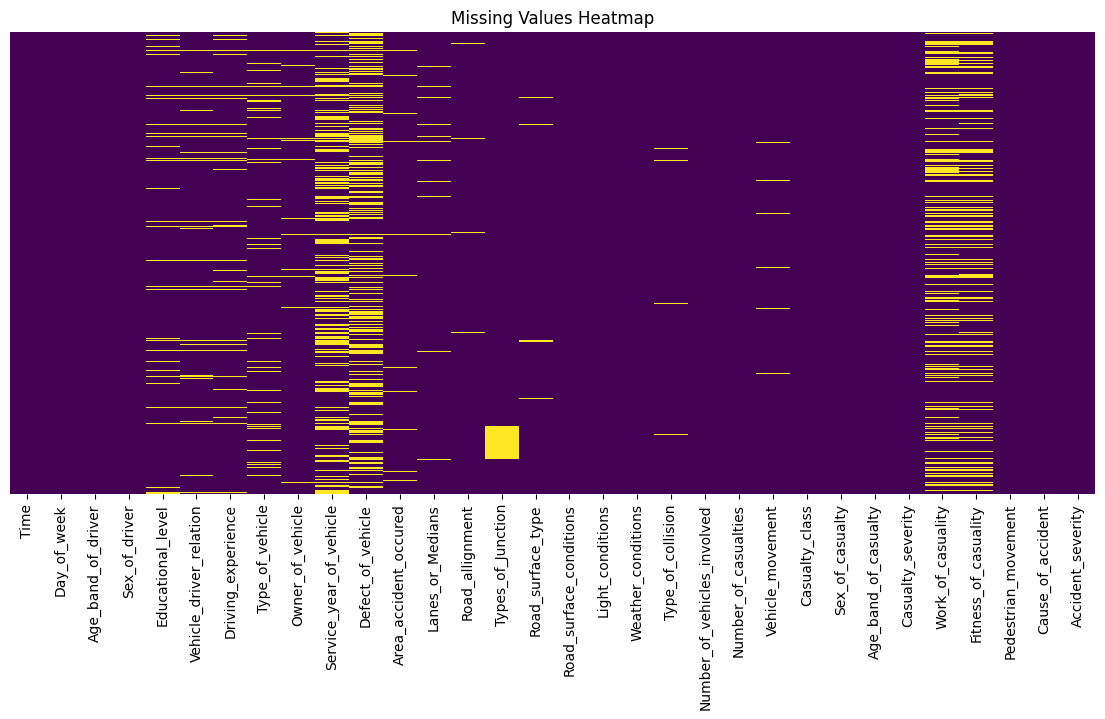

In [35]:
# We check for missing values in the whole data
plt.figure(figsize=(14, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()


In [36]:
# Based on previous studies and dependencies we selected these features (and the target 'Accident_severity')
selected_features = [
    'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Educational_level',
    'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle',
    'Owner_of_vehicle', 'Service_year_of_vehicle', 'Defect_of_vehicle',
    'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment',
    'Types_of_Junction', 'Road_surface_type', 'Road_surface_conditions',
    'Light_conditions', 'Weather_conditions', 'Type_of_collision',
    'Number_of_vehicles_involved', 'Number_of_casualties',
    'Vehicle_movement', 'Cause_of_accident'
]
target = 'Accident_severity'

df = df[selected_features + [target]]

In [38]:
#To handle missing values:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('Unknown')
    else:
        df[col] = df[col].fillna(df[col].mean())

# Label encoding
label_encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Feature-target split
X = df.drop(target, axis=1)
y = df[target]

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)



Fitting 5 folds for each of 12 candidates, totalling 60 fits

All parameter combinations with F1 and Accuracy:

Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100} --> Mean F1: 0.7858 | Mean Accuracy: 0.7876
Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 150} --> Mean F1: 0.7847 | Mean Accuracy: 0.7865
Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200} --> Mean F1: 0.7839 | Mean Accuracy: 0.7857
Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100} --> Mean F1: 0.7834 | Mean Accuracy: 0.7851
Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 150} --> Mean F1: 0.7824 | Mean Accuracy: 0.7844
Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200} --> Mean F1: 0.7838 | Mean Accuracy: 0.7857
Params: {'class_weight': 'bala

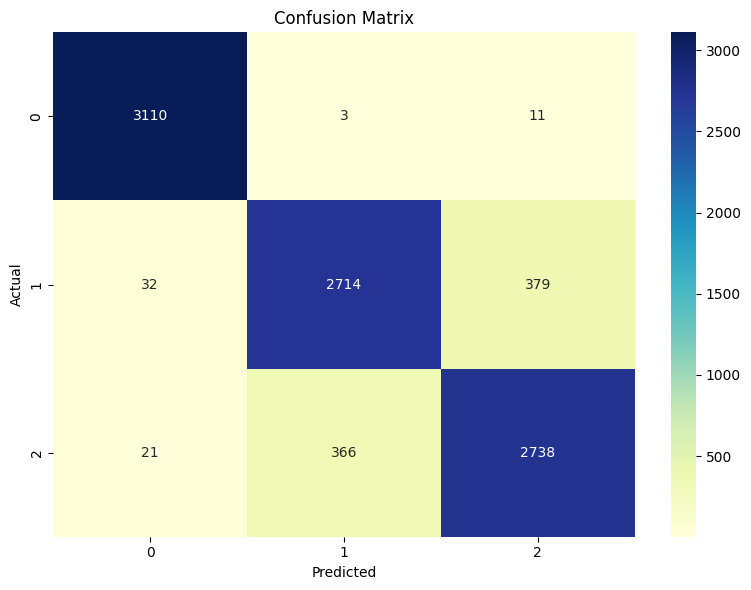

In [39]:
# Grid Search
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    rf, param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='f1_macro',
    return_train_score=True,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Show F1 and Accuracy per configuration
print("\nAll parameter combinations with F1 and Accuracy:\n")
f1_scores = []
acc_scores = []
for i, params in enumerate(grid_search.cv_results_['params']):
    f1 = grid_search.cv_results_['mean_test_score'][i]
    model = RandomForestClassifier(**params, random_state=42)
    acc = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=StratifiedKFold(n_splits=5)).mean()
    f1_scores.append(f1)
    acc_scores.append(acc)
    print(f"Params: {params} --> Mean F1: {f1:.4f} | Mean Accuracy: {acc:.4f}")

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Classification report
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("\nBest Model Evaluation:")
print(report_df)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=label_encoders[target].classes_,
            yticklabels=label_encoders[target].classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


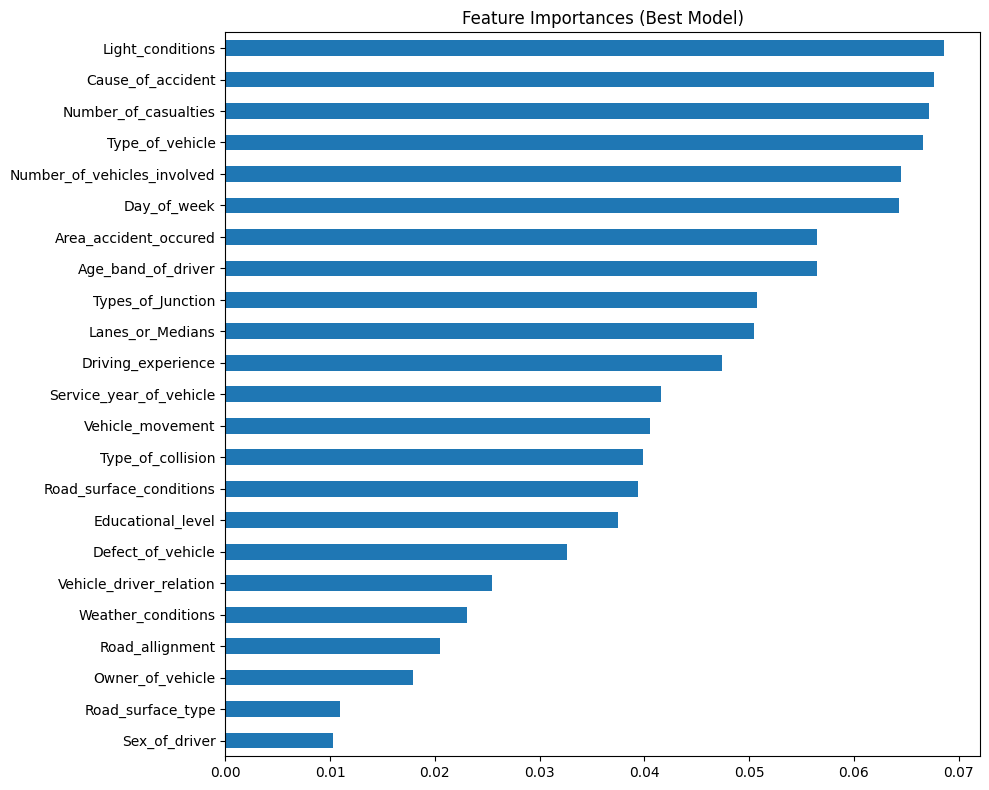

In [40]:
# Feature importance in RF
importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(10, 8))
feat_imp.plot(kind='barh', title='Feature Importances (Best Model)')
plt.tight_layout()
plt.show()
